In [2]:
!uv sync

Resolved 65 packages in 25ms
Uninstalled 30 packages in 23.03s
░░░░░░░░░░░░░░░░░░░░ [0/2] Installing wheels...                                 Uninstalled 30 packages in 23.03s
░░░░░░░░░░░░░░░░░░░░ [0/2] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 2 packages in 6.98s                               
 - asttokens==3.0.1
 - comm==0.2.3
 - debugpy==1.8.17
 - decorator==5.2.1
 - executing==2.2.1
 - ipykernel==7.1.0
 - ipython==9.7.0

## CUDA Testing

In [3]:
# save as test_cuda.py and run: python3 test_cuda.py

import platform

print("=== Environment ===")
print("Platform:", platform.platform())
print("Python:", platform.python_version())

try:
    import torch
except ImportError as e:
    print("\nPyTorch is not installed or not in this Python environment.")
    raise SystemExit(e)

print("\n=== PyTorch / CUDA Info ===")
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)

cuda_available = torch.cuda.is_available()
print("torch.cuda.is_available():", cuda_available)

if not cuda_available:
    print("\nCUDA is NOT available to PyTorch in this environment.")
else:
    # Number of devices
    device_count = torch.cuda.device_count()
    print("torch.cuda.device_count():", device_count)

    for i in range(device_count):
        print(f"  device {i}: {torch.cuda.get_device_name(i)}")

    # Simple tensor test on GPU
    try:
        x = torch.rand(3, 3, device="cuda")
        y = torch.rand(3, 3, device="cuda")
        z = x @ y
        print("\nSuccessfully ran a matrix multiply on CUDA.")
        print("z.device:", z.device)
    except Exception as e:
        print("\nERROR: Allocation or compute on CUDA failed:")
        print(e)

print("\n=== Test Complete ===")

=== Environment ===
Platform: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.31
Python: 3.12.11

=== PyTorch / CUDA Info ===
torch.__version__: 2.9.1+cu128
torch.version.cuda: 12.8
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
  device 0: NVIDIA GeForce RTX 5080

=== PyTorch / CUDA Info ===
torch.__version__: 2.9.1+cu128
torch.version.cuda: 12.8
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
  device 0: NVIDIA GeForce RTX 5080

Successfully ran a matrix multiply on CUDA.
z.device: cuda:0

=== Test Complete ===

Successfully ran a matrix multiply on CUDA.
z.device: cuda:0

=== Test Complete ===


In [ ]:
import torch


print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.9.1+cu128
12.8
91002


## Dataset Loading

In [1]:
import pandas as pd
from pathlib import Path

# Path to the small transactions CSV (relative to this notebook).
DATA_PATH = Path("dataset") / "HI-Small_Trans.csv"

# Load into a DataFrame
small_trans = pd.read_csv(DATA_PATH)

# Quick summary and preview
print(f"Loaded {len(small_trans)} rows; columns: {list(small_trans.columns)}")
small_trans.head()

Loaded 5078345 rows; columns: ['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


# Imbalance Visualization Overview (IBM AML Dataset)

This section adds visual summaries of the strong class imbalance (fraud vs non‑fraud) and related distributions. Run in order after the dataset has been loaded into `small_trans`.



In [2]:
# Text-based imbalance summary for IBM AML dataset
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import pointbiserialr

assert 'small_trans' in globals(), "Load the dataset into 'small_trans' first (see earlier cell)."
df = small_trans.copy()
label_col = 'Is Laundering'
if label_col not in df.columns:
    raise KeyError(f"Expected column '{label_col}' in the dataset.")

print('=' * 72)
print('OVERALL LABEL DISTRIBUTION')
print('=' * 72)
label_counts = df[label_col].value_counts().sort_index()
total = label_counts.sum()
for label, count in label_counts.items():
    pct = 100.0 * count / total
    label_name = 'Fraud (1)' if label == 1 else 'Non-fraud (0)'
    print(f"{label_name:<15}: {count:>7} ({pct:6.3f}%)")
fraud_ratio = label_counts.get(1, 0) / max(total, 1)
print(f"Fraud ratio overall: {fraud_ratio:.5f}")

print('\n' + '=' * 72)
print('NUMERIC AMOUNT SUMMARY PER CLASS')
print('=' * 72)
amount_cols = [c for c in df.columns if any(k in c.lower() for k in ('amount', 'amt', 'value'))]
if amount_cols:
    for col in amount_cols:
        series = pd.to_numeric(df[col], errors='coerce')
        summary = df.groupby(label_col)[col].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
        print(f"Column: {col}")
        print(summary.fillna(0).round(4).to_string())
        print('-' * 40)
else:
    print('No amount-like columns detected for summary.')

print('\n' + '=' * 72)
print('TEMPORAL FRAUD RATES (first 10 windows)')
print('=' * 72)
time_col = next((c for c in df.columns if any(k in c.lower() for k in ('time', 'date', 'timestamp'))), None)
if time_col:
    ts = pd.to_datetime(df[time_col], errors='coerce')
    temp_df = pd.DataFrame({'ts': ts, 'label': df[label_col]}).dropna(subset=['ts'])
    span_days = (temp_df['ts'].max() - temp_df['ts'].min()).days
    freq = 'D' if span_days >= 2 else 'H'
    counts = temp_df.set_index('ts').groupby('label').resample(freq).size().unstack(0).fillna(0)
    counts.columns = [f'label_{c}' for c in counts.columns]
    counts['total'] = counts.sum(axis=1)
    counts['fraud_rate'] = counts.get('label_1', 0) / counts['total'].replace(0, np.nan)
    print(f"Using frequency: {freq}")
    preview = counts[['label_0', 'label_1', 'total', 'fraud_rate']].head(10).fillna(0)
    print(preview.round({'fraud_rate': 4}).to_string())
else:
    print('No timestamp/date column detected for temporal summary.')

print('\n' + '=' * 72)
print('ACCOUNT PARTICIPATION SNAPSHOT (top 10)')
print('=' * 72)
sender_col = next((c for c in df.columns if any(k in c.lower() for k in ('sender', 'originator', 'from', 'account'))), None)
receiver_col = next((c for c in df.columns if any(k in c.lower() for k in ('receiver', 'beneficiary', 'to', 'account.1', 'account_1'))), None)
if sender_col and receiver_col:
    part_df = df[[sender_col, receiver_col, label_col]].copy()
    top_senders = part_df.groupby(sender_col).size().sort_values(ascending=False).head(10)
    top_receivers = part_df.groupby(receiver_col).size().sort_values(ascending=False).head(10)
    fraud_senders = part_df.groupby(sender_col)[label_col].sum().sort_values(ascending=False).head(10)
    fraud_receivers = part_df.groupby(receiver_col)[label_col].sum().sort_values(ascending=False).head(10)
    print(f"Top senders by volume ({sender_col}):\n{top_senders.to_string()}\n")
    print(f"Top receivers by volume ({receiver_col}):\n{top_receivers.to_string()}\n")
    print(f"Top senders by fraud count:\n{fraud_senders.to_string()}\n")
    print(f"Top receivers by fraud count:\n{fraud_receivers.to_string()}\n")
else:
    print('Could not identify sender/receiver columns for participation snapshot.')

print('\n' + '=' * 72)
print('NUMERIC FEATURE CORRELATIONS WITH FRAUD (top 15 abs(r))')
print('=' * 72)
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != label_col]
if num_cols:
    corrs = []
    y = df[label_col].values
    for c in num_cols:
        x = pd.to_numeric(df[c], errors='coerce').fillna(0).values
        try:
            r, p = pointbiserialr(y, x)
        except Exception:
            r, p = np.nan, np.nan
        corrs.append({'feature': c, 'r': r, 'p_value': p})
    corr_df = pd.DataFrame(corrs)
    corr_df['abs_r'] = corr_df['r'].abs()
    corr_df = corr_df.sort_values(by='abs_r', ascending=False).head(15)
    print(corr_df[['feature', 'r', 'p_value']].round(5).to_string(index=False))
else:
    print('No numeric columns (besides label) available for correlation analysis.')

OVERALL LABEL DISTRIBUTION
Non-fraud (0)  : 5073168 (99.898%)
Fraud (1)      :    5177 ( 0.102%)
Fraud ratio overall: 0.00102

NUMERIC AMOUNT SUMMARY PER CLASS
Column: Amount Received
                 count          mean   median           std     min           max
Is Laundering                                                                    
0              5073168  5.957962e+06  1407.51  1.036563e+09  0.0000  1.046302e+12
1                 5177  3.613531e+07  8667.21  1.527919e+09  0.0032  8.485314e+10
----------------------------------------
Column: Amount Paid
                 count          mean   median           std     min           max
Is Laundering                                                                    
0              5073168  4.477000e+06  1410.99  8.688463e+08  0.0000  1.046302e+12
1                 5177  3.613531e+07  8667.21  1.527919e+09  0.0032  8.485314e+10
----------------------------------------

TEMPORAL FRAUD RATES (first 10 windows)
Column: Amount Pa

/tmp/ipykernel_29789/2048982089.py:48: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = temp_df.set_index('ts').groupby('label').resample(freq).size().unstack(0).fillna(0)


Using frequency: D
            label_0  label_1    total  fraud_rate
ts                                               
2022-09-01  1114599      322  1114921      0.0003
2022-09-02   754041      408   754449      0.0005
2022-09-03   206991      391   207382      0.0019
2022-09-04   207023      407   207430      0.0020
2022-09-05   482179      471   482650      0.0010
2022-09-06   481558      531   482089      0.0011
2022-09-07   482254      497   482751      0.0010
2022-09-08   482234      539   482773      0.0011
2022-09-09   653953      514   654467      0.0008
2022-09-10   207883      442   208325      0.0021

ACCOUNT PARTICIPATION SNAPSHOT (top 10)
Top senders by volume (From Bank):
From Bank
70     449859
10      81629
12      79754
1       62211
15      52511
220     52417
20      41008
3       38413
7       31086
211     30451

Top receivers by volume (To Bank):
To Bank
10     42547
12     41872
15     38721
220    30625
1      30115
3      25627
7      23029
20     22048
28     

## Dataset Pre-processing

In [3]:
import numpy as np

# convert hex account numbers to int
hex_to_int = np.vectorize(lambda x: int(x, 16))

# create adjacency lists to represent the graph
source = hex_to_int(small_trans['Account'])
target = hex_to_int(small_trans['Account.1'])

In [4]:
from torch_geometric.data import Data
import torch

# Map account IDs to a compact 0..N-1 index space to avoid huge sparse IDs
# Concatenate unique accounts from source/target and factorize
all_accounts = np.concatenate([source, target])
unique_accounts, inverse_idx = np.unique(all_accounts, return_inverse=True)
num_nodes = unique_accounts.shape[0]
# Rebuild source/target as compact indices
source_idx = inverse_idx[:source.shape[0]]
target_idx = inverse_idx[source.shape[0]:]

# Build edge_index
edge_index = torch.tensor(np.vstack([source_idx, target_idx]), dtype=torch.long)

# Create Data object
data = Data(edge_index=edge_index, num_nodes=num_nodes)
print('num_nodes:', num_nodes, 'num_edges:', edge_index.size(1))
print(data)

/mnt/d/SFSU/CSC871/csc865-anti-money-laundering-ibm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_nodes: 515080 num_edges: 5078345
Data(edge_index=[2, 5078345], num_nodes=515080)


In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
import torch

# extract individual edge features
time = pd.to_datetime(small_trans['Timestamp']).astype('int64') / 1e9
amount_paid = small_trans['Amount Paid'].to_numpy()
amount_received = small_trans['Amount Received'].to_numpy()

# combine edge features into single tensor (standardised numeric block)
numeric_features = np.column_stack([time, amount_paid, amount_received])
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_features)
edge_features = torch.from_numpy(numeric_scaled).float()

# create edge labels
fraud_label = torch.tensor(small_trans['Is Laundering'].to_numpy(), dtype=torch.long)

# attach features and labels to PyG Data
data.edge_attr = edge_features
data.edge_label = fraud_label
print(data)


Data(edge_index=[2, 5078345], num_nodes=515080, edge_attr=[5078345, 3], edge_label=[5078345])


In [6]:
# chronological 60/20/20 split by edge index order
num_edges = data.edge_index.size(1)
train_end = int(0.6 * num_edges)
val_end = int(0.8 * num_edges)

train_mask = torch.zeros(num_edges, dtype=torch.bool)
val_mask = torch.zeros(num_edges, dtype=torch.bool)
test_mask = torch.zeros(num_edges, dtype=torch.bool)
train_mask[:train_end] = True
val_mask[train_end:val_end] = True
test_mask[val_end:] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
print('Masks set:', train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item())

Masks set: 3047007 1015669 1015669


In [7]:
# Hyperparameters

# Increase edge_batch_size if you have ample memory and want fewer edge chunks per epoch.
edge_batch_size = 1024
# Toggle GPU usage; set to False to keep everything on CPU even if CUDA is visible.
use_gpu = torch.cuda.is_available()
# Ratio of sampled negatives to each positive edge during fallback training.
neg_pos_ratio = 2.0
# Scale factor applied to the empirical class imbalance when computing pos_weight.
pos_weight_scale = 0.35
# Optional manual override for pos_weight (set to a float to force a value).
pos_weight_override = None
# Number of epochs to train for.
epochs = 20
# Hidden dimension for the GNN and edge classifier.
num_hid = 64
# Smaller learning rate to keep updates stable on imbalanced data.
learn_rate = 5e-4
# Weight decay for the optimizer.
decay = 1e-4
# Gradient clipping threshold (set <=0 to disable).
grad_clip = 1.0
# False positive rate target used when calibrating the decision threshold on validation data.
fpr_target = 0.05
# Minimum epochs before enabling regular recalibration so the loss can settle.
calibrate_warmup = 6
# How often (in epochs) to re-fit the validation ROC and refresh the threshold after warmup.
calibrate_every = 3
# Blend factor applied when updating the threshold (0=no change, 1=replace).
threshold_blend = 0.2
# Hard floor on the decision threshold to avoid runaway false positives.
threshold_floor = 0.2
# Hard ceiling on the decision threshold for numerical safety.
threshold_ceiling = 0.95
# Maximum allowed validation positive fraction before skipping a threshold update.
max_val_pos_frac = 0.45
# Maximum allowed validation FPR before skipping a threshold update.
max_val_fpr = 0.25

In [8]:
# PyG GNN model and edge classification training (batched)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure data object exists with edge_index, edge_attr, edge_label, and masks
assert data is not None, 'PyG Data not constructed yet'
num_nodes = data.num_nodes
num_edges = data.edge_index.size(1)
if getattr(data, 'edge_attr', None) is None:
    raise RuntimeError('Edge features missing. Run Cell 12 (edge feature construction) before this cell.')
edge_feat_dim = data.edge_attr.size(1)

# Create simple node features if none exist (e.g., degree or identity)
if getattr(data, 'x', None) is None:
    deg = torch.zeros((num_nodes, 1), dtype=torch.float)
    deg.scatter_add_(0, data.edge_index[0].view(-1,1), torch.ones((num_edges,1)))
    data.x = deg  # use degree as a simple node feature

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim):
        super().__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, edge_dim=edge_dim)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels, edge_dim=edge_dim)
    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        return x

class EdgeClassifier(nn.Module):
    def __init__(self, node_hidden, edge_feat_dim, hidden=num_hid):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(node_hidden*2 + edge_feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x, edge_index, edge_attr):
        u, v = edge_index
        h = torch.cat([x[u], x[v], edge_attr], dim=1)
        return self.mlp(h).squeeze(-1)
    def score_pairs(self, x, u, v, edge_attr):
        h = torch.cat([x[u], x[v], edge_attr], dim=1)
        return self.mlp(h).squeeze(-1)


In [9]:
import importlib, math, torch, sys, subprocess, os
from torch_geometric.loader import LinkNeighborLoader

# Detect if neighbor sampling backend (pyg_lib or torch_sparse) is available
backend_ok = bool(importlib.util.find_spec("pyg_lib") or importlib.util.find_spec("torch_sparse"))
fallback_splits = {}
if not backend_ok:
    print("Neighbor sampling backend missing: install 'pyg-lib' (preferred) or 'torch-sparse'.")
    torch_ver = torch.__version__.split('+')[0]
    cuda_ver = torch.version.cuda
    if cuda_ver is None:
        cuda_tag = 'cpu'
    else:
        cuda_tag = 'cu' + cuda_ver.replace('.', '')
    index_url = f'https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html'
    print('Suggested install command (run in a terminal):')
    print(f"{sys.executable} -m pip install pyg-lib torch-sparse -f {index_url}")
    print('Fallback to full-graph edge training will be used until a backend is installed.')
    print('Note: pyg_lib currently does not support some newer PyTorch versions; fallback will be used if install fails.')

requested_gpu = use_gpu and torch.cuda.is_available()
device = torch.device('cuda') if requested_gpu else torch.device('cpu')
if device.type == 'cuda':
    dev_index = device.index if device.index is not None else torch.cuda.current_device()
    print(f'Using GPU device: {torch.cuda.get_device_name(dev_index)} (index {dev_index}).')
else:
    if use_gpu and not torch.cuda.is_available():
        print('CUDA requested but not available; falling back to CPU.')
    else:
        print('Using CPU for training (set use_gpu=True and ensure CUDA availability to use GPU).')

gnn = GNN(in_channels=data.x.size(1), hidden_channels=num_hid, edge_dim=edge_feat_dim).to(device)
clf = EdgeClassifier(node_hidden=num_hid, edge_feat_dim=edge_feat_dim, hidden=num_hid*2).to(device)

params = list(gnn.parameters()) + list(clf.parameters())
optimizer = torch.optim.Adam(params, lr=learn_rate, weight_decay=decay)

# Build edge_label_index and edge_label tensors for each split
train_edge_label_index = data.edge_index[:, data.train_mask]
train_edge_label = data.edge_label[data.train_mask]

val_edge_label_index = data.edge_index[:, data.val_mask]
val_edge_label = data.edge_label[data.val_mask]

test_edge_label_index = data.edge_index[:, data.test_mask]
test_edge_label = data.edge_label[data.test_mask]

train_pos = int(train_edge_label.sum().item())
train_total = int(train_edge_label.numel())
train_neg = max(train_total - train_pos, 0)
base_pos_weight = (train_neg / max(train_pos, 1)) if train_pos > 0 else 1.0
if pos_weight_override is not None:
    pos_weight_value = float(pos_weight_override)
else:
    pos_weight_value = max(base_pos_weight * pos_weight_scale, 1.0)
pos_weight_tensor = torch.tensor(pos_weight_value, dtype=torch.float, device=device)
print(f'Train edges: {train_total} | positives: {train_pos} ({train_pos / max(train_total,1):.6f}) | pos_weight {pos_weight_value:.2f} | neg/pos ratio target {neg_pos_ratio:.1f}:1')

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# Safer defaults for batch size & neighbors to reduce per-batch time/memory
batch_size = edge_batch_size  # configurable via hyperparameter cell
num_neighbors = [10, 5]  # fewer neighbors for smaller subgraphs

fallback_mode = not backend_ok
if backend_ok:
    print(f'Backend OK: {backend_ok} | batch_size: {batch_size} | num_neighbors: {num_neighbors}')
    train_loader = LinkNeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        edge_label_index=train_edge_label_index,
        edge_label=train_edge_label,
        shuffle=True,
        neg_sampling_ratio=0.0
    )
    val_loader = LinkNeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        edge_label_index=val_edge_label_index,
        edge_label=val_edge_label,
        shuffle=False,
        neg_sampling_ratio=0.0
    )
    test_loader = LinkNeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        edge_label_index=test_edge_label_index,
        edge_label=test_edge_label,
        shuffle=False,
        neg_sampling_ratio=0.0
    )
else:
    def _split_edges(mask):
        return {
            'edge_label_index': data.edge_index[:, mask],
            'edge_label': data.edge_label[mask],
            'edge_attr': data.edge_attr[mask]
        }
    fallback_splits = {
        'train': _split_edges(data.train_mask),
        'val': _split_edges(data.val_mask),
        'test': _split_edges(data.test_mask)
    }
    train_loader = fallback_splits['train']
    val_loader = fallback_splits['val']
    test_loader = fallback_splits['test']
    train_count = fallback_splits['train']['edge_label'].numel()
    val_count = fallback_splits['val']['edge_label'].numel()
    test_count = fallback_splits['test']['edge_label'].numel()
    chunk_size = max(int(edge_batch_size), 1)
    print(f'Fallback mode active on {device.type.upper()} device: full-graph embeddings with edge chunks of {chunk_size} (train edges {train_count}, val {val_count}, test {test_count}).')
    print('edge_batch_size controls chunking in this mode; install pyg-lib or torch-sparse to enable true neighbor sampling.')


Neighbor sampling backend missing: install 'pyg-lib' (preferred) or 'torch-sparse'.
Suggested install command (run in a terminal):
/mnt/d/SFSU/CSC871/csc865-anti-money-laundering-ibm/.venv/bin/python -m pip install pyg-lib torch-sparse -f https://data.pyg.org/whl/torch-2.9.1+cu128.html
Fallback to full-graph edge training will be used until a backend is installed.
Note: pyg_lib currently does not support some newer PyTorch versions; fallback will be used if install fails.
Using GPU device: NVIDIA GeForce RTX 5080 (index 0).
Train edges: 3047007 | positives: 2865 (0.000940) | pos_weight 371.88 | neg/pos ratio target 2.0:1
Fallback mode active on CUDA device: full-graph embeddings with edge chunks of 1024 (train edges 3047007, val 1015669, test 1015669).
edge_batch_size controls chunking in this mode; install pyg-lib or torch-sparse to enable true neighbor sampling.
Train edges: 3047007 | positives: 2865 (0.000940) | pos_weight 371.88 | neg/pos ratio target 2.0:1
Fallback mode active on 

In [10]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve
from tqdm import tqdm
import time
import math
import gc
from contextlib import nullcontext


def _gather_label_edge_attr(batch):
    # Map local edges (u,v) -> position in batch.edge_index to gather edge_attr for labeled edges
    e_u = batch.edge_index[0].tolist()
    e_v = batch.edge_index[1].tolist()
    pos_map = {(eu, ev): i for i, (eu, ev) in enumerate(zip(e_u, e_v))}
    lu = batch.edge_label_index[0].tolist()
    lv = batch.edge_label_index[1].tolist()
    idx = [pos_map[(u, v)] for u, v in zip(lu, lv)]
    return batch.edge_attr[idx]


def _iter_fallback_chunks(split, chunk_size, index_subset=None):
    edge_index = split['edge_label_index']
    edge_attr = split['edge_attr']
    edge_label = split['edge_label']
    if index_subset is None:
        indices = torch.arange(edge_label.size(0))
    else:
        indices = index_subset
    total = indices.numel()
    for start in range(0, total, chunk_size):
        sel = indices[start:min(start + chunk_size, total)]
        yield edge_index[:, sel], edge_attr[sel], edge_label[sel]


def _sample_balanced_indices(labels, ratio):
    pos_idx = torch.nonzero(labels == 1, as_tuple=False).view(-1)
    neg_idx = torch.nonzero(labels == 0, as_tuple=False).view(-1)
    if pos_idx.numel() == 0:
        return torch.zeros(0, dtype=torch.long)
    neg_needed = int(math.ceil(pos_idx.numel() * ratio))
    if neg_idx.numel() == 0:
        combined = pos_idx
    else:
        neg_needed = min(max(neg_needed, pos_idx.numel()), neg_idx.numel())
        perm = torch.randperm(neg_idx.numel())
        sampled_neg = neg_idx[perm[:neg_needed]]
        combined = torch.cat([pos_idx, sampled_neg])
    shuffle = torch.randperm(combined.numel())
    return combined[shuffle]


def _select_threshold(y_true, probs, target_fpr=0.02):
    if y_true.size == 0:
        return 0.5
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    if np.isnan(thresholds).all():
        return 0.5
    # Remove infinities for stability
    finite_mask = np.isfinite(thresholds)
    fpr, tpr, thresholds = fpr[finite_mask], tpr[finite_mask], thresholds[finite_mask]
    if thresholds.size == 0:
        return 0.5
    if target_fpr is not None:
        ok = np.where(fpr <= target_fpr)[0]
        if ok.size > 0:
            idx = ok[np.argmax(tpr[ok])]
        else:
            idx = np.argmin(fpr)
    else:
        youden = tpr - fpr
        idx = np.argmax(youden)
    thr = thresholds[idx]
    if np.isnan(thr):
        thr = 0.5
    return float(np.clip(thr, 1e-6, 1 - 1e-6))


def _summarise_predictions(y_true, probs, threshold):
    preds = (probs >= threshold).astype(np.int64)
    if preds.size == 0:
        return {
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'fpr': 0.0,
            'acc': 0.0,
            'pos_frac': 0.0,
            'threshold': threshold,
            'preds': preds,
            'probs': probs,
            'labels': y_true
        }
    acc = (preds == y_true).mean()
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, preds, labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / max(tn + fp, 1)
    else:
        fpr = 0.0
    pos_frac = preds.mean()
    return {
        'precision': float(pr),
        'recall': float(rc),
        'f1': float(f1),
        'fpr': float(fpr),
        'acc': float(acc),
        'pos_frac': float(pos_frac),
        'threshold': float(threshold),
        'preds': preds,
        'probs': probs,
        'labels': y_true
    }


def train_one_epoch(use_amp=True, log_every=200, neg_ratio=3.0):
    gnn.train(); clf.train()
    amp_enabled = use_amp and (device.type == 'cuda') and not fallback_mode
    scaler = torch.amp.GradScaler('cuda') if amp_enabled else None
    clip_enabled = (grad_clip is not None) and (grad_clip > 0)
    if fallback_mode:
        optimizer.zero_grad()
        x = gnn(data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device))
        split = fallback_splits['train']
        labels_cpu = split['edge_label'].cpu()
        selected_indices = _sample_balanced_indices(labels_cpu, neg_ratio)
        if selected_indices.numel() == 0:
            print('No positive edges found in training split; cannot update model.')
            optimizer.zero_grad(set_to_none=True)
            return float('nan')
        total_edges = selected_indices.numel()
        chunk_size = max(int(edge_batch_size), 1)
        loss_terms = []
        for edge_idx_chunk, edge_attr_chunk, label_chunk in _iter_fallback_chunks(split, chunk_size, selected_indices):
            u = edge_idx_chunk[0].to(device)
            v = edge_idx_chunk[1].to(device)
            edge_attr = torch.nan_to_num(edge_attr_chunk, nan=0.0, posinf=0.0, neginf=0.0).to(device)
            edge_label = label_chunk.to(device).float()
            logits = clf.score_pairs(x, u, v, edge_attr)
            loss = criterion(logits, edge_label)
            if not torch.isfinite(loss):
                print('Non-finite loss encountered in fallback chunk; try lowering pos_weight or learning rate.')
                return float('nan')
            loss_terms.append(loss * edge_label.numel())
        if not loss_terms:
            print('Balanced sampling produced no batches; skipping epoch.')
            optimizer.zero_grad(set_to_none=True)
            return 0.0
        loss_total = torch.stack(loss_terms).sum() / max(total_edges, 1)
        loss_total.backward()
        if clip_enabled:
            torch.nn.utils.clip_grad_norm_(params, max_norm=grad_clip)
        optimizer.step()
        return float(loss_total.detach().cpu())
    # Neighbor-sampling path (backend available)
    total_loss = 0.0
    total_count = 0
    t0 = time.time()
    for i, batch in enumerate(tqdm(train_loader, desc='train_batches'), 1):
        optimizer.zero_grad()
        batch = batch.to(device)
        context = torch.amp.autocast('cuda') if scaler is not None else nullcontext()
        with context:
            x = gnn(batch.x, batch.edge_index, batch.edge_attr)
            label_edge_attr = _gather_label_edge_attr(batch)
            logits = clf.score_pairs(x, batch.edge_label_index[0], batch.edge_label_index[1], label_edge_attr)
            labels_float = batch.edge_label.float()
            loss = criterion(logits, labels_float)
        if not torch.isfinite(loss):
            print(f'  batch {i} produced non-finite loss; skipping update.')
            optimizer.zero_grad(set_to_none=True)
            continue
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            if clip_enabled:
                torch.nn.utils.clip_grad_norm_(params, max_norm=grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if clip_enabled:
                torch.nn.utils.clip_grad_norm_(params, max_norm=grad_clip)
            optimizer.step()
        batch_size_local = batch.edge_label.numel()
        total_loss += loss.item() * batch_size_local
        total_count += batch_size_local
        if i % max(log_every, 1) == 0:
            print(f'  batch {i} | batch_loss {loss.item():.4f} | elapsed {time.time()-t0:.1f}s')
    return total_loss / max(total_count, 1)


def evaluate_split(split_name, threshold=None, calibrate=False):
    gnn.eval(); clf.eval()
    chunk_size = max(int(edge_batch_size), 1)
    labels_list = []
    probs_list = []
    if fallback_mode:
        split = fallback_splits[split_name]
        with torch.no_grad():
            x = gnn(data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device))
            for edge_idx_chunk, edge_attr_chunk, label_chunk in _iter_fallback_chunks(split, chunk_size):
                u = edge_idx_chunk[0].to(device)
                v = edge_idx_chunk[1].to(device)
                edge_attr = torch.nan_to_num(edge_attr_chunk, nan=0.0, posinf=0.0, neginf=0.0).to(device)
                logits = clf.score_pairs(x, u, v, edge_attr)
                probs = torch.sigmoid(logits).detach().cpu()
                probs_list.append(probs)
                labels_list.append(label_chunk.detach().cpu())
    else:
        loader_map = {'train': train_loader, 'val': val_loader, 'test': test_loader}
        loader = loader_map[split_name]
        with torch.no_grad():
            for batch in tqdm(loader, desc=f'{split_name}_batches'):
                batch = batch.to(device)
                x = gnn(batch.x, batch.edge_index, batch.edge_attr)
                label_edge_attr = _gather_label_edge_attr(batch)
                logits = clf.score_pairs(x, batch.edge_label_index[0], batch.edge_label_index[1], label_edge_attr)
                probs = torch.sigmoid(logits).detach().cpu()
                probs_list.append(probs)
                labels_list.append(batch.edge_label.detach().cpu())
    if not labels_list:
        empty = np.array([])
        return {
            'acc': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'fpr': 0.0,
            'pos_frac': 0.0,
            'threshold': threshold if threshold is not None else 0.5,
            'preds': empty,
            'probs': empty,
            'labels': empty
        }
    labels = torch.cat(labels_list).numpy().astype(np.int64)
    probs = torch.cat(probs_list).numpy().astype(np.float32)
    if calibrate or threshold is None:
        chosen_threshold = _select_threshold(labels, probs, target_fpr=fpr_target)
    else:
        chosen_threshold = threshold
    summary = _summarise_predictions(labels, probs, chosen_threshold)
    return summary


log_every = 200 if not fallback_mode else 0
calibrated_threshold = 0.5
for epoch in range(1, epochs+1):
    epoch_t0 = time.time()
    avg_loss = train_one_epoch(use_amp=(device.type == 'cuda'), log_every=log_every, neg_ratio=neg_pos_ratio)
    epoch_time = time.time() - epoch_t0
    if not math.isfinite(avg_loss):
        print(f'Epoch {epoch:02d} skipped due to non-finite loss.')
        continue
    warmup_ready = epoch >= calibrate_warmup
    should_calibrate = (epoch == 1) or (warmup_ready and ((epoch - calibrate_warmup) % max(calibrate_every, 1) == 0))
    train_metrics = evaluate_split('train', threshold=calibrated_threshold)
    val_metrics = evaluate_split('val', threshold=calibrated_threshold, calibrate=should_calibrate)
    if should_calibrate:
        new_threshold = val_metrics['threshold']
        allow_update = np.isfinite(new_threshold)
        if allow_update and val_metrics['pos_frac'] > max_val_pos_frac:
            print(f"  skip threshold update: val_pos_frac {val_metrics['pos_frac']:.3f} exceeds {max_val_pos_frac:.3f}")
            allow_update = False
        if allow_update and val_metrics['fpr'] > max_val_fpr:
            print(f"  skip threshold update: val_fpr {val_metrics['fpr']:.3f} exceeds {max_val_fpr:.3f}")
            allow_update = False
        if allow_update:
            if epoch == 1:
                calibrated_threshold = float(np.clip(new_threshold, threshold_floor, threshold_ceiling))
            else:
                blended = ((1.0 - threshold_blend) * calibrated_threshold) + (threshold_blend * new_threshold)
                calibrated_threshold = float(np.clip(blended, threshold_floor, threshold_ceiling))
    print(
        f"Epoch {epoch:02d} | loss {avg_loss:.4f} | time {epoch_time:.1f}s | "
        f"train_acc {train_metrics['acc']:.3f} | val_acc {val_metrics['acc']:.3f} | "
        f"val_precision {val_metrics['precision']:.3f} | val_recall {val_metrics['recall']:.3f} | "
        f"val_f1 {val_metrics['f1']:.3f} | val_fpr {val_metrics['fpr']:.4f} | val_thresh {calibrated_threshold:.4f} | "
        f"val_pos_frac {val_metrics['pos_frac']:.5f}"
    )
    if device.type == 'cuda':
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
    gc.collect()

Epoch 01 | loss 95494.3359 | time 1.4s | train_acc 0.408 | val_acc 0.799 | val_precision 0.001 | val_recall 0.221 | val_f1 0.002 | val_fpr 0.2007 | val_thresh 0.9500 | val_pos_frac 0.20071
Epoch 02 | loss 37108.8008 | time 0.4s | train_acc 0.437 | val_acc 0.361 | val_precision 0.001 | val_recall 0.520 | val_f1 0.002 | val_fpr 0.6389 | val_thresh 0.9500 | val_pos_frac 0.63876
Epoch 02 | loss 37108.8008 | time 0.4s | train_acc 0.437 | val_acc 0.361 | val_precision 0.001 | val_recall 0.520 | val_f1 0.002 | val_fpr 0.6389 | val_thresh 0.9500 | val_pos_frac 0.63876
Epoch 03 | loss 11435.7354 | time 0.4s | train_acc 0.200 | val_acc 0.088 | val_precision 0.001 | val_recall 0.771 | val_f1 0.002 | val_fpr 0.9130 | val_thresh 0.9500 | val_pos_frac 0.91287
Epoch 03 | loss 11435.7354 | time 0.4s | train_acc 0.200 | val_acc 0.088 | val_precision 0.001 | val_recall 0.771 | val_f1 0.002 | val_fpr 0.9130 | val_thresh 0.9500 | val_pos_frac 0.91287
Epoch 04 | loss 1139.3503 | time 0.5s | train_acc 0.188

Test accuracy: 0.628514
Test precision: 0.001472
Test recall: 0.443645
Test F1: 0.002933
False positive rate: 0.371258
Predicted positive fraction: 0.371347
Decision threshold: 0.95


44

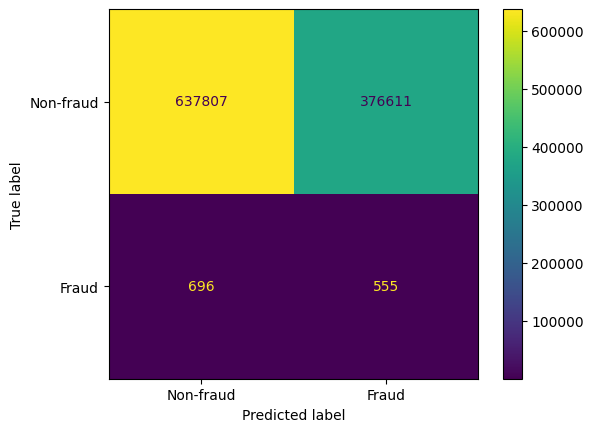

In [11]:
import gc

test_metrics = evaluate_split('test', threshold=calibrated_threshold)
labels = test_metrics['labels']
preds = test_metrics['preds']
print('Test accuracy:', round(test_metrics['acc'], 6))
print('Test precision:', round(test_metrics['precision'], 6))
print('Test recall:', round(test_metrics['recall'], 6))
print('Test F1:', round(test_metrics['f1'], 6))
print('False positive rate:', round(test_metrics['fpr'], 6))
print('Predicted positive fraction:', round(test_metrics['pos_frac'], 6))
print('Decision threshold:', round(test_metrics['threshold'], 6))

if labels.size > 0 and preds.size > 0:
    cm = confusion_matrix(labels, preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Non-fraud', 'Fraud'])
    disp.plot(values_format='d')
else:
    print('Not enough classes in test to compute CM/recall/FPR.')

if device.type == 'cuda':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
gc.collect()